In [75]:
# Cell 1: Import and Load Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

fundamentals = pd.read_csv(r"C:\Users\cinco\Desktop\DATA FOR SCRIPTS\Charles\fundamentals_20250119_225604.csv")
options_data = pd.read_csv(r"C:\Users\cinco\Desktop\DATA FOR SCRIPTS\Charles\SPY_type_ALL_strikes_10_strat_SINGLE_20250119_234821.csv")  # Add your combined file path here
print("Available columns in options_data:")
print(options_data.columns.tolist())

Available columns in options_data:
['symbol', 'status', 'strategy', 'interval', 'isDelayed', 'isIndex', 'daysToExpiration', 'interestRate', 'underlyingPrice', 'volatility', 'optionType', 'expirationDate', 'strikePrice', 'description', 'exchangeName', 'bidPrice', 'askPrice', 'lastPrice', 'mark', 'bidSize', 'askSize', 'lastSize', 'highPrice', 'lowPrice', 'openPrice', 'closePrice', 'totalVolume', 'tradeDate', 'quoteTimeInLong', 'tradeTimeInLong', 'netChange', 'delta', 'gamma', 'theta', 'vega', 'rho', 'timeValue', 'openInterest', 'isInTheMoney', 'theoreticalOptionValue', 'theoreticalVolatility', 'isMini', 'isNonStandard', 'optionDeliverablesList', 'expirationType', 'lastTradingDay', 'multiplier', 'settlementType', 'deliverableNote', 'isIndexOption', 'percentChange', 'markChange', 'markPercentChange', 'isPennyPilot', 'intrinsicValue', 'optionRoot']


In [77]:
def get_atm_options(options_data, n=5):
    current_price = options_data['underlyingPrice'].iloc[0]
    
    # Separate calls and puts
    calls = options_data[options_data['optionType'] == 'CALL']
    puts = options_data[options_data['optionType'] == 'PUT']
    
    # Calculate distance from ATM for each option
    calls['distance_from_atm'] = abs(calls['strikePrice'] - current_price)
    puts['distance_from_atm'] = abs(puts['strikePrice'] - current_price)
    
    # Get ATM options
    atm_calls = calls[calls['strikePrice'] >= current_price].nsmallest(n, 'distance_from_atm')
    atm_puts = puts[puts['strikePrice'] <= current_price].nsmallest(n, 'distance_from_atm')
    
    # Get OTM options moving towards ATM
    otm_calls = calls[calls['strikePrice'] > current_price].nlargest(n, 'distance_from_atm')
    otm_puts = puts[puts['strikePrice'] < current_price].nlargest(n, 'distance_from_atm')
    
    print(f"Current Price: ${current_price:.2f}")
    print("\nNearest ATM Call Options:")
    print(atm_calls[['symbol', 'strikePrice', 'mark', 'theoreticalVolatility']].to_string())
    print("\nTop OTM Call Options:")
    print(otm_calls[['symbol', 'strikePrice', 'mark', 'theoreticalVolatility']].to_string())
    print("\nNearest ATM Put Options:")
    print(atm_puts[['symbol', 'strikePrice', 'mark', 'theoreticalVolatility']].to_string())
    print("\nTop OTM Put Options:")
    print(otm_puts[['symbol', 'strikePrice', 'mark', 'theoreticalVolatility']].to_string())

get_atm_options(options_data)

Current Price: $597.69

Nearest ATM Call Options:
                   symbol  strikePrice  mark  theoreticalVolatility
5   SPY   250121C00598000        598.0  1.74                   29.0
15  SPY   250122C00598000        598.0  2.62                   29.0
25  SPY   250123C00598000        598.0  3.22                   29.0
35  SPY   250124C00598000        598.0  3.92                   29.0
45  SPY   250127C00598000        598.0  4.38                   29.0

Top OTM Call Options:
                    symbol  strikePrice   mark  theoreticalVolatility
179  SPY   250417C00620000        620.0   7.15                   29.0
199  SPY   250516C00620000        620.0  10.55                   29.0
219  SPY   250620C00620000        620.0  14.29                   29.0
229  SPY   250630C00620000        620.0  14.87                   29.0
239  SPY   250718C00620000        620.0  16.82                   29.0

Nearest ATM Put Options:
                    symbol  strikePrice  mark  theoreticalVolatility
384 

C:\Users\cinco\AppData\Local\Temp\ipykernel_20232\2355502355.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['distance_from_atm'] = abs(calls['strikePrice'] - current_price)
C:\Users\cinco\AppData\Local\Temp\ipykernel_20232\2355502355.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puts['distance_from_atm'] = abs(puts['strikePrice'] - current_price)


In [78]:
def select_option_by_symbol(symbol, options_data):
    if symbol in options_data['symbol'].values:
        option_data = options_data[options_data['symbol'] == symbol].iloc[0]
        option_type = 'call' if option_data['optionType'] == 'CALL' else 'put'
    else:
        raise ValueError("Symbol not found in options data")
    
    return option_data, option_type

# Input symbol here
symbol = "SPY   250122P00593000"  # Replace with your chosen symbol
selected_option, option_type = select_option_by_symbol(symbol, options_data)

print("\nSelected Option Details:")
fields_to_display = [
    'symbol', 
    'strikePrice', 
    'expirationDate', 
    'mark',  # Changed from 'mark' to 'markPrice'
    'theoreticalVolatility', 
    'delta',
    'optionType'
]

for field in fields_to_display:
    print(f"{field}: {selected_option[field]}")


Selected Option Details:
symbol: SPY   250122P00593000
strikePrice: 593.0
expirationDate: 2025-01-22:2
mark: 1.42
theoreticalVolatility: 29.0
delta: -999.0
optionType: PUT


In [79]:
class BinomialConfig:
    def __init__(self, selected_option, fundamentals_data):
        # Get underlying price from the description
        self.initial_price = float(selected_option['description'].split()[2])
        self.strike_price = float(selected_option['strikePrice'])
        
        # Convert volatility from whole number to decimal (e.g., 29 -> 0.29)
        self.volatility = float(selected_option['theoreticalVolatility']) / 100
        
        # Convert interest rate from whole number to decimal (e.g., 4.78 -> 0.0478)
        self.risk_free_rate = float(selected_option['interestRate']) / 100
        
        # Get dividend information
        symbol = selected_option['symbol'].split()[0]  # Get the underlying symbol (SPY)
        dividend_info = fundamentals_data[fundamentals_data['symbol'] == symbol].iloc[0]
        self.div_yield = float(dividend_info['divYield']) if pd.notna(dividend_info['divYield']) else 0.0
        
        self.periods = 4
        self.option_type = option_type
        
        # Calculate factors using the converted rates
        self.up_factor = np.exp(self.volatility * np.sqrt(1/self.periods))
        self.down_factor = 1/self.up_factor
        
        # Adjust probability calculations for dividends
        effective_rate = self.risk_free_rate - self.div_yield
        self.risk_neutral_prob_up = (1 + effective_rate - self.down_factor) / (self.up_factor - self.down_factor)
        self.risk_neutral_prob_down = (self.up_factor - (1 + effective_rate)) / (self.up_factor - self.down_factor)

In [88]:
def generate_option_tree(stock_tree, config):
    # Initialize option tree with zeros
    option_tree = np.zeros_like(stock_tree)
    periods = config.periods
    
    # Fill in terminal values (last column)
    for j in range(periods + 1):
        if config.option_type == 'call':
            option_tree[periods, j] = max(0, stock_tree[periods, j] - config.strike_price)
        else:  # put option
            option_tree[periods, j] = max(0, config.strike_price - stock_tree[periods, j])
    
    # Work backwards through the tree
    for i in range(periods-1, -1, -1):
        for j in range(i + 1):
            # Risk-neutral pricing formula
            future_up = option_tree[i+1, j+1]
            future_down = option_tree[i+1, j]
            
            # Discount factor for one period
            discount = 1 / (1 + config.risk_free_rate/periods)
            
            # Calculate option value at this node
            option_tree[i, j] = discount * (
                config.risk_neutral_prob_up * future_up +
                config.risk_neutral_prob_down * future_down
            )
    
    return option_tree

# Generate both trees before analysis
stock_tree = generate_stock_tree(config)
option_tree = generate_option_tree(stock_tree, config)

C:\Users\cinco\AppData\Local\Temp\ipykernel_20232\2330848020.py:15: RuntimeWarning: overflow encountered in exp
  stock_tree[i, j] = np.exp(log_price)


Model Price: $581.29
Market Price: $1.42
Difference: $579.87
Delta (Model): -0.0000


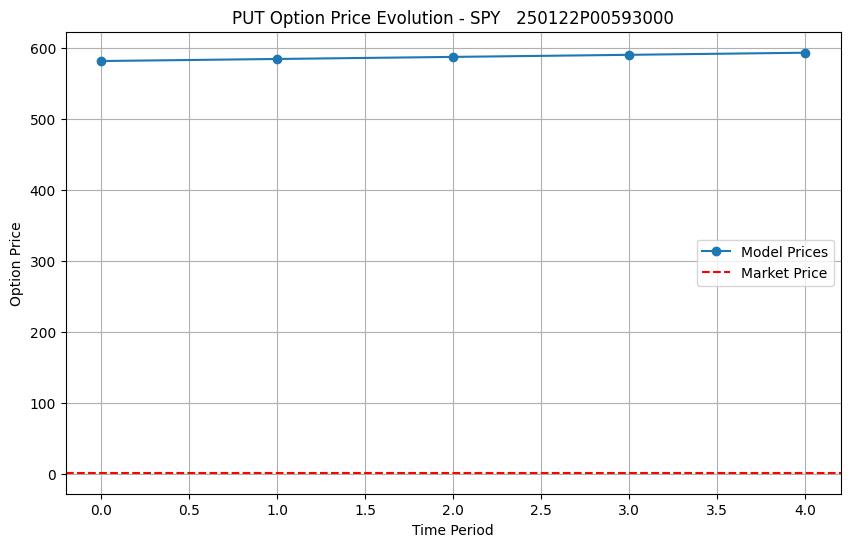

In [86]:
def analyze_results(config, option_tree, selected_option):
    model_price = option_tree[0, 0]
    market_price = selected_option['mark']
    
    # Calculate theoretical delta
    delta_up = option_tree[1, 1]
    delta_down = option_tree[1, 0]
    price_up = stock_tree[1, 1]
    price_down = stock_tree[1, 0]
    theoretical_delta = (delta_up - delta_down) / (price_up - price_down)
    
    print(f"Model Price: ${model_price:.2f}")
    print(f"Market Price: ${market_price:.2f}")
    print(f"Difference: ${model_price - market_price:.2f}")
    print(f"Delta (Model): {theoretical_delta:.4f}")
    
    # Only show market Greeks if they're available (not -999)
    if selected_option['delta'] != -999:
        print(f"Delta (Market): {selected_option['delta']:.4f}")
    if selected_option['gamma'] != -999:
        print(f"Gamma (Market): {selected_option['gamma']:.4f}")
    if selected_option['theta'] != -999:
        print(f"Theta (Market): {selected_option['theta']:.4f}")
    if selected_option['vega'] != -999:
        print(f"Vega (Market): {selected_option['vega']:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(config.periods + 1), [option_tree[i, i] for i in range(config.periods + 1)], 
             marker='o', label='Model Prices')
    plt.axhline(y=market_price, color='r', linestyle='--', label='Market Price')
    plt.title(f'{config.option_type.upper()} Option Price Evolution - {selected_option["symbol"]}')
    plt.xlabel('Time Period')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()
analyze_results(config, option_tree, selected_option)